# Setup

## Imports

In [2]:
from IPython.display import clear_output

!pip3 install pyprind

clear_output()

In [3]:
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as poly

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gzip

import os
import glob
import time
import random
import json
import copy
import pyprind
import tqdm
import itertools
import pickle as pkl
from dataclasses import dataclass, field
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Utility

In [4]:
def one_hot(x, num_classes=2):
    return torch.nn.functional.one_hot(x, num_classes=num_classes).squeeze(1)

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Arguments

In [6]:
def get_gates(gates, coefficients, image_size, channels):
    def get_mixing(coefficient, image_size, channel_size):
        def get_layer(coefficient, image_size):
            total = image_size**2
            pure = int(coefficient*total)
            random = total - pure
            t = torch.cat((torch.ones((pure,)), torch.zeros((random,))), dim=0)
            idx = torch.randperm(t.nelement())
            t = t.view(-1)[idx].view(1, image_size, image_size)
            return t
        return torch.cat([get_layer(coefficient, image_size) for _ in range(channel_size)], dim=0)
    gating = []
    for i in range(len(gates)):
        gating.append((gates[i], get_mixing(coefficients[i], image_size, channels[i])))
    return tuple(gating)

def get_exposure(channel_size, k):
    return tuple(torch.where(torch.rand(channel_size, 2**k)>0.5, torch.ones(1,), torch.zeros(1,)).tolist())

In [7]:
@dataclass
class TrainingArgs():

    seed: int = 1
    lr: float = 1e-2
    batch_size: int = 32
    num_workers: int = os.cpu_count()
    max_epochs: str = 200
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    size: int = int(1e4)
    bound: int = 10
    input_size: int = 1
    output_size: int = 2
    image_size: int = 32
    channels: tuple = (16, 16, 16, 16, 16)
    use_bias: bool = False
    k: int = 1
    beta: int = 1
    weights: torch.Tensor = None
    mixing: float = (0.5, 0.5, 0.5, 0.5, 0.5)
    gates: tuple = ('AND', 'AND', 'AND', 'AND', 'AND')
    gating: tuple = get_gates(gates, mixing, image_size, channels)
    architecture: str = 'DNN'
    mode: str = 'Random'
    exposure: tuple = get_exposure(len(channels), k)

    data: tuple = None

    root_dir: str = './data/cifar-10'
    checkpoint: str = './checkpoints'
    experiment: str = None

args = TrainingArgs()

# Models

## Shallow

In [8]:
class Shallow(torch.nn.Module):
    def __init__(self, args):
        super(Shallow, self).__init__()
        self.args = args
        
        
        self.act1f = torch.where(torch.rand((self.args.output_size, self.args.channels[0]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc1v = nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=self.args.use_bias)

        self.act2f = torch.where(torch.rand((self.args.output_size, self.args.channels[1]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc2v = nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=self.args.use_bias)
        
        self.act3f = torch.where(torch.rand((self.args.output_size, self.args.channels[2]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc3v = nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=self.args.use_bias)

        self.act4f = torch.where(torch.rand((self.args.output_size, self.args.channels[3]))>0.5, torch.ones(1,), torch.zeros(1,)).to(self.args.device)
        self.fc4v = nn.Linear(in_features=self.args.channels[2], out_features=self.args.channels[3], bias=self.args.use_bias)

        self.fc5v = nn.Linear(in_features=self.args.channels[3], out_features=self.args.input_size, bias=self.args.use_bias)

        self.gap = nn.AvgPool2d(kernel_size=32, stride=1, padding=0, ceil_mode=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, gate):

        preact = torch.stack([self.act1f[gate[i], :] for i in range(len(gate))])
        out = self.fc1v(x) * preact

        preact = torch.stack([self.act2f[gate[i], :] for i in range(len(gate))])
        out = self.fc2v(out) * preact

        preact = torch.stack([self.act3f[gate[i], :] for i in range(len(gate))])
        out = self.fc3v(out) * preact

        preact = torch.stack([self.act4f[gate[i], :] for i in range(len(gate))])
        out = self.fc4v(out) * preact

        out = self.fc5v(out)

        return out

In [9]:
shallow = Shallow(args)

In [10]:
x = torch.ones(2, 1)

z = shallow(x, [0, 1])

# Train

In [11]:
def compute_gradients(z, model):
    grads = []
    for t in z:
        grad_ = torch.autograd.grad(t, model.parameters(), create_graph=True, allow_unused=True)
        grad_ = [t.reshape(-1) for t in grad_]
        grad_ = torch.cat(grad_, dim=0)
        grads.append(grad_.unsqueeze(0))
    grads = torch.cat(grads, dim=0)
    return grads

In [12]:
model = Shallow(args)
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

x = torch.rand(1, 1).repeat(2, 1)
y = torch.tensor([[-1.], [1.]])

I = torch.eye(2)

In [14]:
cache = {'e': [], 'k_t': [], 'e_dash': []}

z = model(x, [0, 1])
e = z - y
e_dash = e
cache['e'].append(e)
cache['e_dash'].append(e_dash)


for _ in range(50):
    z = model(x, [0, 1])

    grads = compute_gradients(z, model)
    k_t = torch.matmul(grads, grads.T)
    print(k_t.shape)
    optimizer.zero_grad()
    loss = criterion(z, y)
    loss.backward()
    optimizer.step()

    z = model(x, [0, 1])
    e = z - y
    
    e_dash = torch.matmul(I-args.lr*k_t, cache['e_dash'][-1])
    cache['e'].append(e)
    cache['k_t'].append(k_t)
    cache['e_dash'].append(e_dash)

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])


In [ ]:
a = []
b = []
for i in range(len(cache['e'])):
    try:
        et = cache['e'][i]
        et = et/(torch.matmul(et.T, et))
        kt = cache['k_t'][i] /torch.trace(kt)
        kt1 = cache['k_t'][i+1] /torch.trace(kt1)

        a.append(torch.matmul(et.T, torch.matmul(kt, et)).item())
        b.append(torch.matmul(et.T, torch.matmul(kt1, et)).item())
    except:
        pass

a = np.array(a)
b = np.array(b)

In [ ]:
a, b

(array([0.0286468 , 0.02796805, 0.02868368, 0.02800531, 0.0287232 ,
        0.02804517, 0.02876537, 0.0280876 , 0.02881019, 0.02813262,
        0.02885767, 0.02818025, 0.02890782, 0.02823049, 0.02896065,
        0.02828335, 0.02901616, 0.02833883, 0.02907438, 0.02839695,
        0.02913531, 0.02845771, 0.02919895, 0.02852114, 0.02926533,
        0.02858724, 0.02933444, 0.02865602, 0.02940631, 0.02872749,
        0.02948095, 0.02880167, 0.02955836, 0.02887857, 0.02963857,
        0.0289582 , 0.0297216 , 0.02904057, 0.02980744, 0.02912571,
        0.02989612, 0.02921363, 0.02998765, 0.02930433, 0.03008205,
        0.02939784, 0.03017934, 0.02949419, 0.03027953]),
 array([9.37432647e-01, 8.55555525e-04, 9.38681781e-01, 8.56734172e-04,
        9.40017164e-01, 8.57991807e-04, 9.41439331e-01, 8.59328313e-04,
        9.42948163e-01, 8.60744331e-04, 9.44544613e-01, 8.62239918e-04,
        9.46228325e-01, 8.63815425e-04, 9.47999299e-01, 8.65471375e-04,
        9.49858546e-01, 8.67207476e-04, 9.

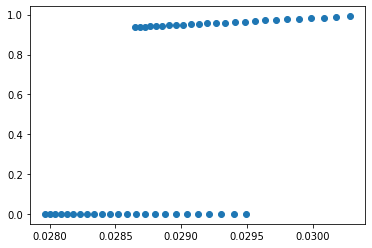

In [ ]:
plt.scatter(a, b)

In [ ]:
z = model(x, [0, 1])
e1 = z - y

grads = compute_gradients(z, model)
k_t = torch.matmul(grads, grads.T)

optimizer.zero_grad()
loss = criterion(z, y)
loss.backward()
optimizer.step()

z = model(x, [0, 1])
e2 = z - y

err = e2 - torch.matmul(I-2*args.lr*k_t, e1)
print(err)

In [ ]:
y

In [ ]:
z

In [ ]:
e1

In [ ]:
e2

In [ ]:
k_t

In [ ]:
torch.matmul(I-2*args.lr*k_t, e1)